In [1]:
%matplotlib widget
%load_ext autoreload
%autoreload 2

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
from astropy.nddata import Cutout2D
import astropy.units as u
from scipy.ndimage import gaussian_filter
from fklib import mapview

# Read FITS header correctly

In [ ]:
f = "/Users/fkeruzore/Data/Misc/ACT_148_equ_season_4_1way_v3_src_free.fits"
# f = "/Users/fkeruzore/Downloads/cmb_cib_nulled/SPTSZ_Planck_ra0h50dec-50_cmb_cib_nulled_ymap_half1.fits.gz"
# f = "./nk2_actj0215_15.fits"

hdu_data = 0
hdulist = fits.open(f)
d = hdulist[hdu_data].data
h = hdulist[hdu_data].header
wcs = WCS(h)
fig, ax = mapview.fitsview(f, hdu_data, cmap="seismic", imrange="sym")

## Find the coordinates of the FITS center

In [ ]:
pix_center = np.array([h[f"NAXIS{ii}"] // 2 for ii in (1, 2)])
ax.plot(*pix_center, "k*")
ra, dec = wcs.all_pix2world([pix_center], 0)[0]
coords_center = SkyCoord(ra=ra * u.deg, dec=dec * u.deg)
print(coords_center.to_string("hmsdms"))

## Find pixel size

In [ ]:
coords_pixs = wcs.all_pix2world([pix_center, pix_center + 1], 1)
dx, dy = np.abs(coords_pixs[1] - coords_pixs[0])

In [ ]:
dx * 3600, dy * 3600

In [ ]:
h["CDELT2"] * 3600

In [ ]:
np.array(d.shape) * h["CDELT2"]

# Make ACT cutout

In [74]:
f = "/Users/fkeruzore/Data/Misc/ACT_148_equ_season_4_1way_v3_src_free.fits"
hdu_data = 0
hdulist = fits.open(f)
d = hdulist[hdu_data].data
h = hdulist[hdu_data].header
wcs = WCS(h)

In [75]:
pix_center = np.array([h[f"NAXIS{ii}"] // 2 for ii in (1, 2)])
ra, dec = wcs.all_pix2world([pix_center], 0)[0]
coords_center = SkyCoord(ra=ra * u.deg, dec=dec * u.deg)

(<Figure size 640x480 with 2 Axes>, <WCSAxesSubplot:>)

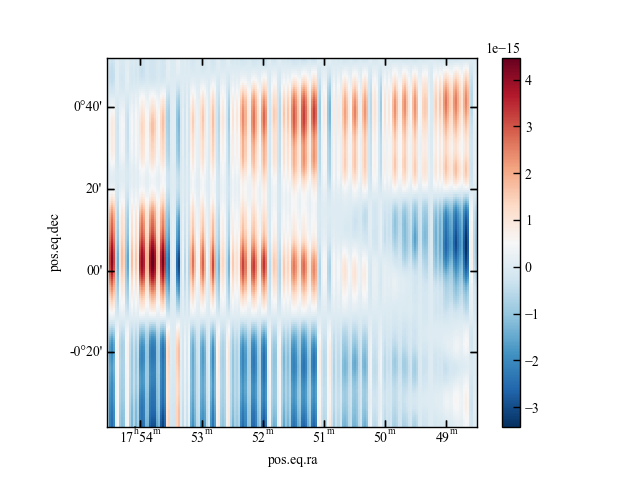

In [76]:
cutout = Cutout2D(d, coords_center, (1.5 + h["CDELT2"]) * u.deg, wcs=wcs)
mapview.mapview(cutout.data, wcs=cutout.wcs)

(<Figure size 640x480 with 2 Axes>, <WCSAxesSubplot:>)

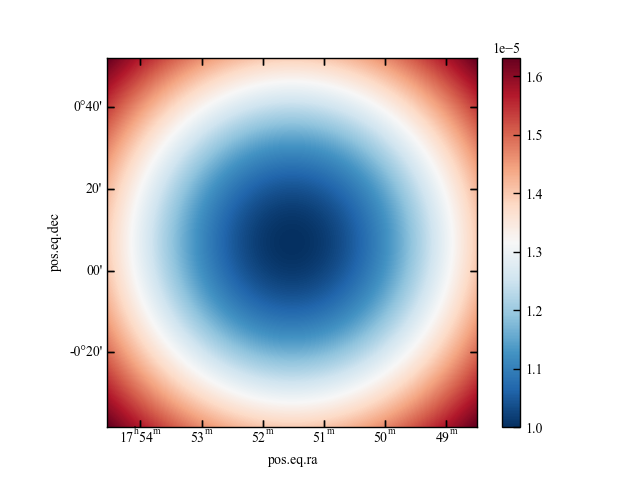

In [85]:
hnpix = data_towrite.shape[0] // 2
rmap = np.hypot(*np.meshgrid(np.arange(-hnpix, hnpix + 1), np.arange(-hnpix, hnpix + 1)))
data_towrite = 1e-5 * (2.0 - np.exp(-0.5 * (rmap / hnpix) ** 2))

hdulist_new = fits.HDUList(
    [
        fits.PrimaryHDU(),
        fits.ImageHDU(data=data_towrite, header=cutout.wcs.to_header(), name="SZ_Y"),
        fits.ImageHDU(data=data_towrite, header=cutout.wcs.to_header(), name="SZ_RMS"),
    ]
)
hdulist_new.writeto("./ACTlike.fits", overwrite=True)
mapview.fitsview("./ACTlike.fits", 1, smooth=0.0)